# Network Analysis
Advancing the utility of Statistical Process Control

In [1]:
# Import libraries
import process.improvement as pi
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.ticker import FixedLocator

In [2]:
# Specify process toleranc, target, and spec limits
tolerance = 4.8
target = 6
USL = target + (tolerance/2)
LSL = target - (tolerance/2)

In [3]:
# Specify path to data
dataset_url = "https://raw.githubusercontent.com/jimlehner/ddi-datasets/refs/heads/main/data/network-analysis-manufacturing-process-data.csv"

In [4]:
# Read csv from URL
def get_data() -> pd.DataFrame:
    return pd.read_csv(dataset_url, index_col=0)

# Get data
df = get_data()
# Change data scale to mm
df.reset_index(inplace=True)
df['Observation'] = df['Observation'].astype('string')
# Display dataframe
df.head()

,Observation,Machine 1,Machine 2,Machine 3,Machine 4,Machine 5,Machine 6,Machine 7,Machine 8,Machine 5 Original
0,1,6.64,5.97,6.20,4.59,5.96,5.34,5.50,4.87,7.14
1,2,5.07,5.48,6.22,4.13,5.69,5.83,5.65,5.15,6.90
2,3,5.13,5.58,6.57,5.36,6.03,5.28,5.90,5.58,7.52
3,4,4.75,7.28,6.77,5.78,6.40,6.28,4.78,6.24,7.25
4,5,6.11,6.14,6.58,3.49,5.65,4.97,5.21,5.55,7.65


In [5]:
# Trasnform dataframe into list of dataframes
list_of_dfs = [df[[col]].rename(columns={col: 'Values'}) for col in df.columns[1:-1]]

In [36]:
# Create list of labels to use in the network analysis
list_of_labels = df.columns.tolist()
# Reduce list to just machine names
list_of_labels = list_of_labels[1:9]

In [7]:
# Create dataframe of just original Machine 5 data
M5 = df[['Observation','Machine 5 Original']]
M5 = M5.rename(columns={'Machine 5 Original':'Machine 5'})
M5.dtypes

Observation     string
Machine 5      float64
dtype: object

## Figure 3: Process behavior chart of Machine 5

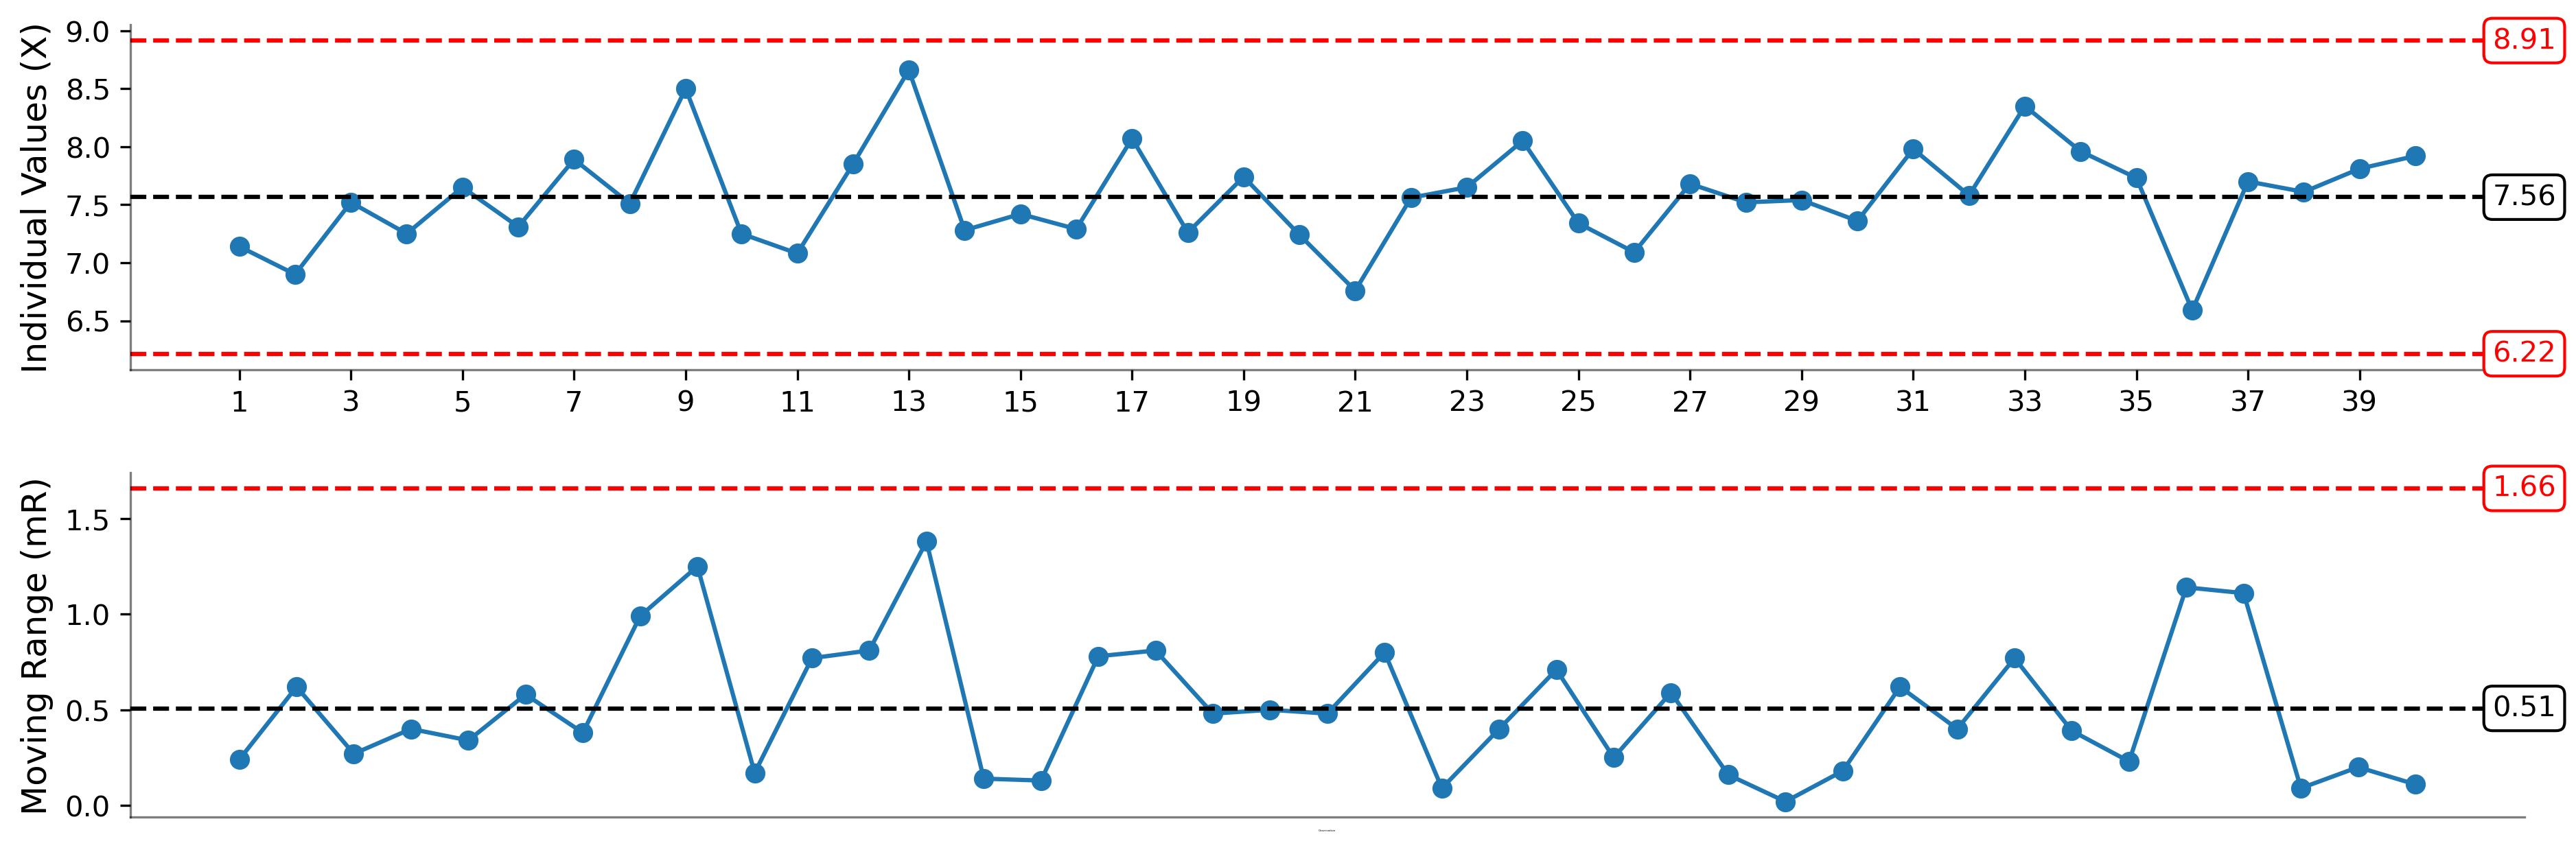

In [8]:
M5_results = pi.pbc(M5, 'Machine 5', 'Observation', fig_size=(15,5))

In [9]:
# Calculate numeric summaries for machine 5
M5_mean = round(M5['Machine 5'].mean(),2)
M5_std = round(M5['Machine 5'].std(),2)
M5_mean
M5_std

0.44

## Figure 4: Histogram of Machine 5

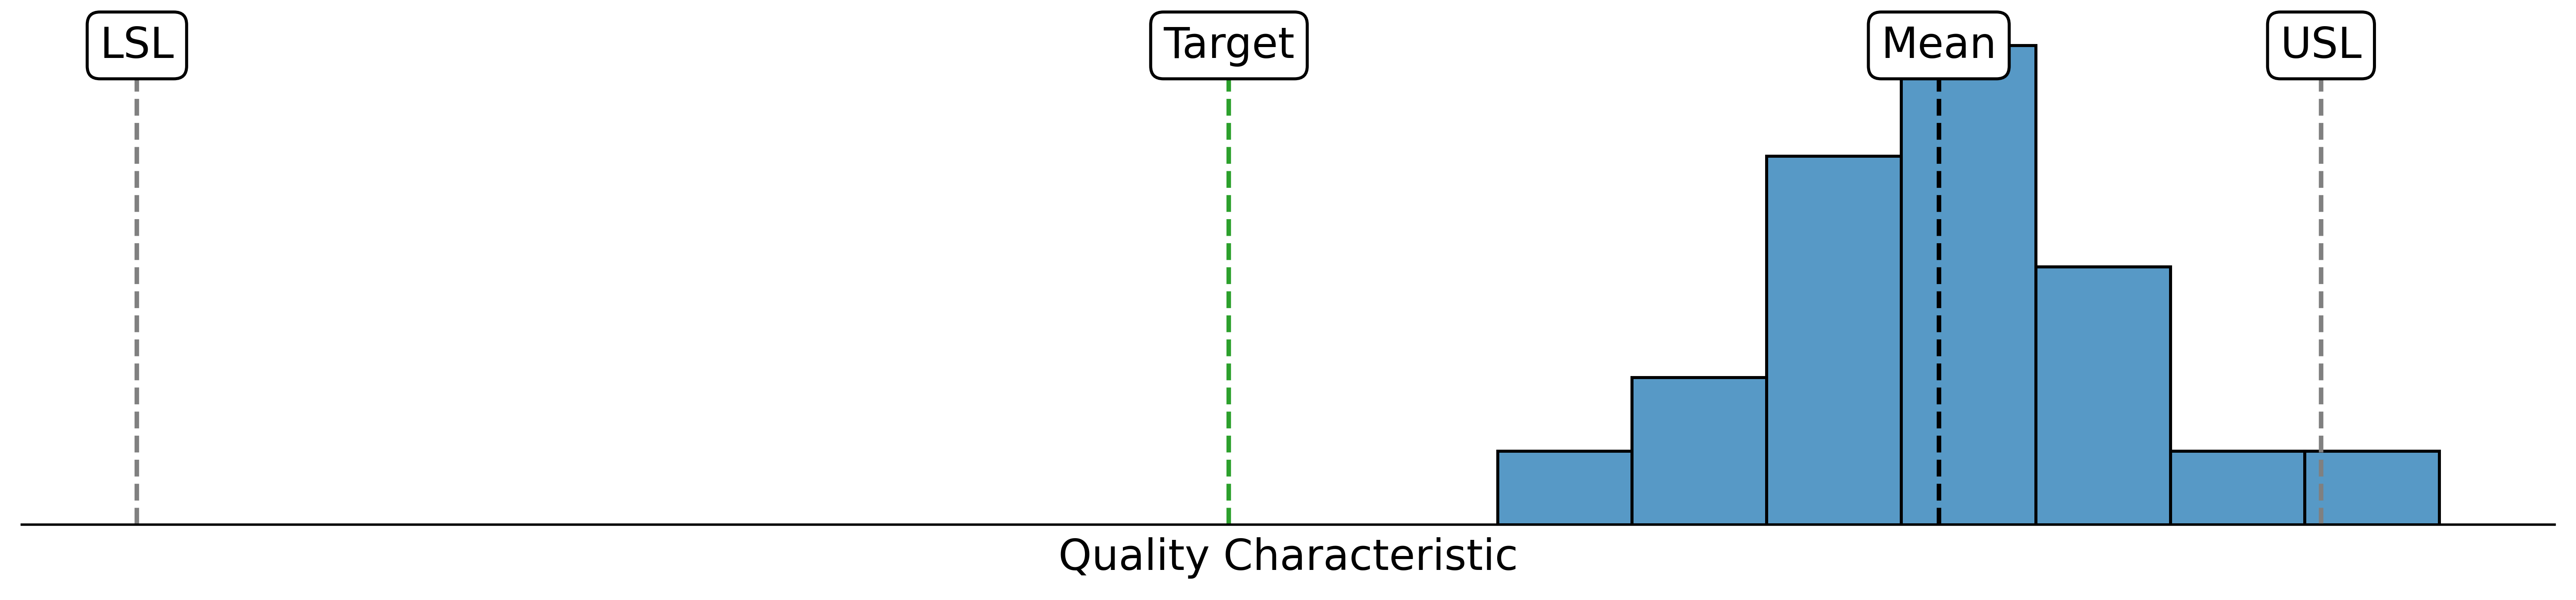

In [11]:
fig, ax = plt.subplots(figsize=(15,3), dpi=500)

hist = sns.histplot(data=M5, x='Machine 5')

# Get max height 
y_max = max([patch.get_height() for patch in hist.patches])

# Common annotations
annotation_props = {
    'ha':'center',
    'va':'center',
    'fontsize':14,
    'bbox':dict(facecolor='white', edgecolor='black', boxstyle='round')
}

# Annotations for target, USL, LSL, and mean
annotations = [
    ('Target', target, 'tab:green'),
    ('USL', USL, 'gray'),
    ('LSL', LSL, 'gray'),
    ('Mean', M5_mean, 'black')
]

# Add vertical lines and annotations
for label, x_value, color in annotations:
    linestyle = '--'  # Dashed line for 'Mean'
    ax.axvline(x_value, ls=linestyle, c=color)   # Use the specified color
    ax.annotate(label, xy=(x_value, y_max), **annotation_props)

# Remove x and y ticks and y label 
ax.set(yticks=[], xticks=[], ylabel='')
# Set x-axis label 
ax.set_xlabel('Quality Characteristic', fontsize=14)
# Despine the figure
sns.despine(left=True)

plt.show()

## Figure 5: PBC/Histogram for adjusted M5

In [12]:
M5_adjusted = df[['Observation', 'Machine 5']]

# Calculate process limits
mean = round(M5_adjusted['Machine 5'].mean(),2)
mr = abs(round(M5_adjusted['Machine 5'].diff(),2))
amr = round(mr.mean(),2)
# Numeric constants
C1 = 2.660
C2 = 3.278
UPL = mean + (C1*amr)
LPL = mean - (C1*amr)
URL = C2*amr

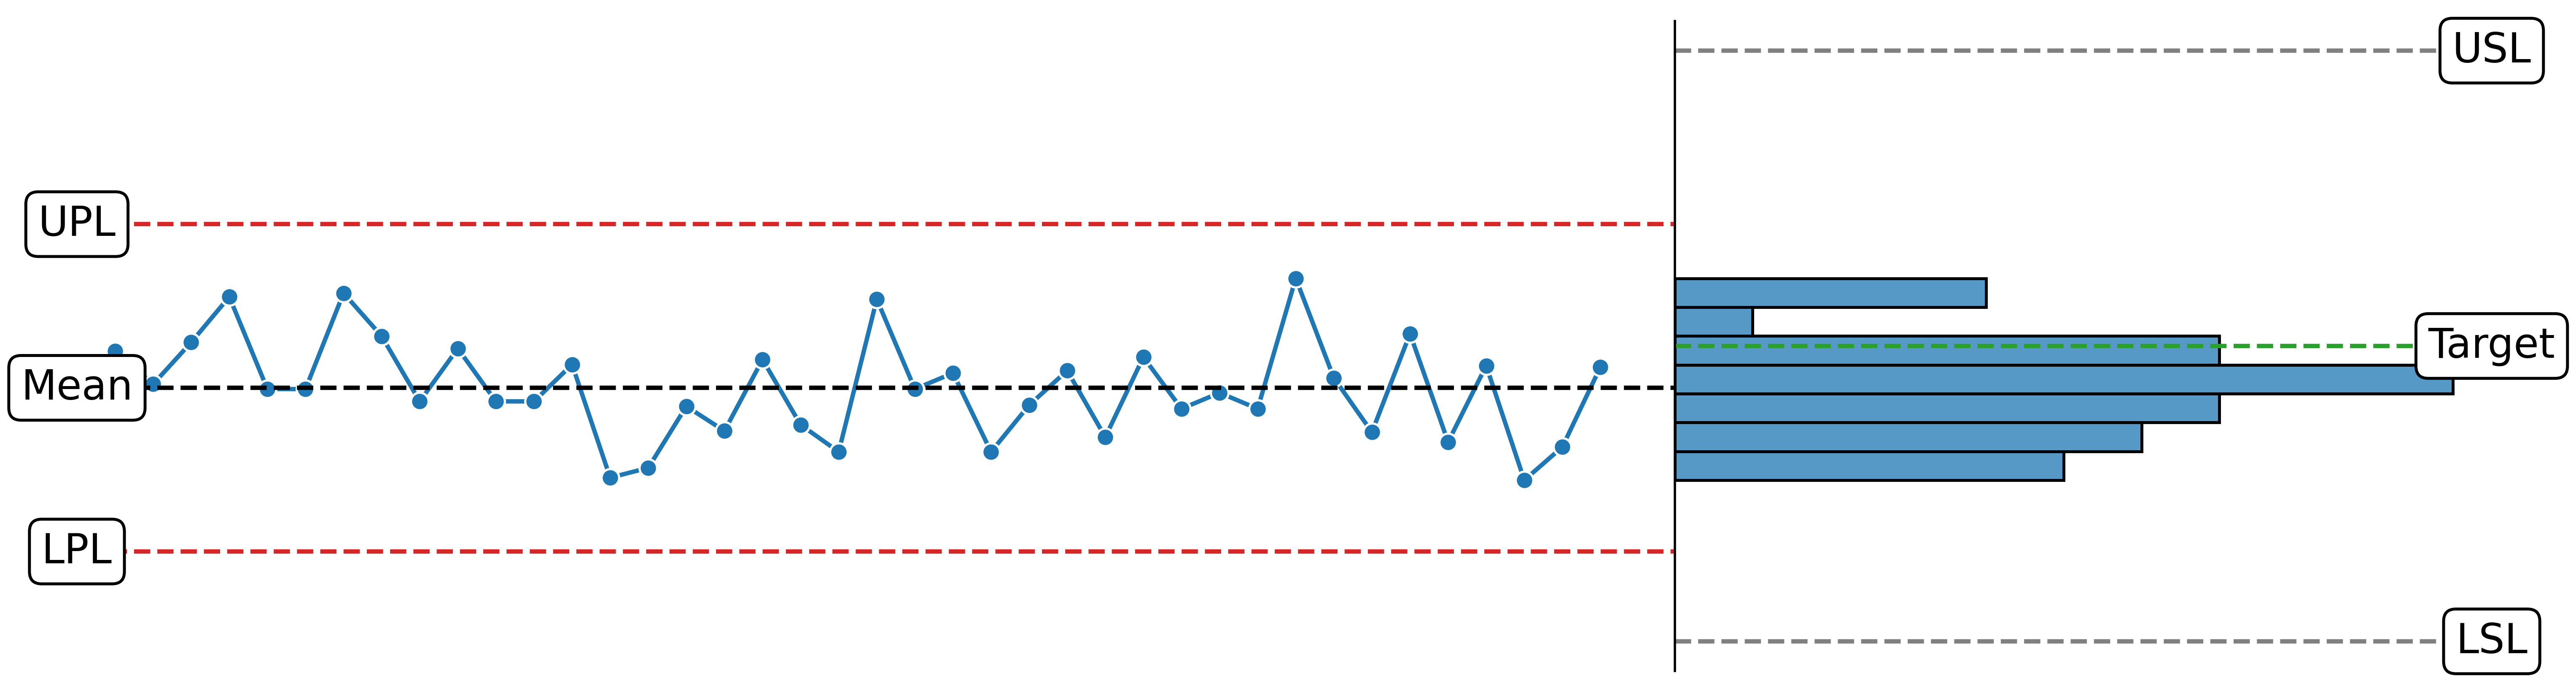

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=500,
                       figsize=(15,4),
                      gridspec_kw={'width_ratios': [2, 1]})
plt.subplots_adjust(wspace=0)

sns.lineplot(data=M5_adjusted, 
             y='Machine 5', 
             x='Observation', 
             marker='o',
             ax=ax[0])

sns.histplot(data=M5_adjusted, y='Machine 5')

# Horizontal lines for each axis
horizontal_lines = [
    (ax[0], [('UPL', UPL, 'tab:red'), ('LPL', LPL, 'tab:red'), ('Mean', mean, 'black')]),
    (ax[1], [('Target', target, 'tab:green'), ('USL', USL, 'gray'), ('LSL', LSL, 'gray')])
]

# Add horizontal lines
for axis, lines in horizontal_lines:
    for _, y_value, color in lines:
        axis.axhline(y_value, ls='--', c=color)

# Annotations for each axis
all_annotations = [
    (ax[0], -1, [('UPL', UPL), ('LPL', LPL), ('Mean', mean)]),  # Axis 0
    (ax[1], 10.5, [('USL', USL), ('LSL', LSL), ('Target', target)])  # Axis 1
]

# Add annotations
for axis, x_value, annotations in all_annotations:
    for label, y_value in annotations:
        axis.annotate(label, xy=(x_value, y_value), **annotation_props)

# Despine figure
sns.despine()

ax[0].spines['left'].set_visible(False)

for ax_item in [ax[0], ax[1]]:
    ax_item.spines['bottom'].set_alpha(0)
    ax_item.set(yticks=[], xticks=[], ylabel='', xlabel='')

plt.show()

## Figure 6: Network analysis

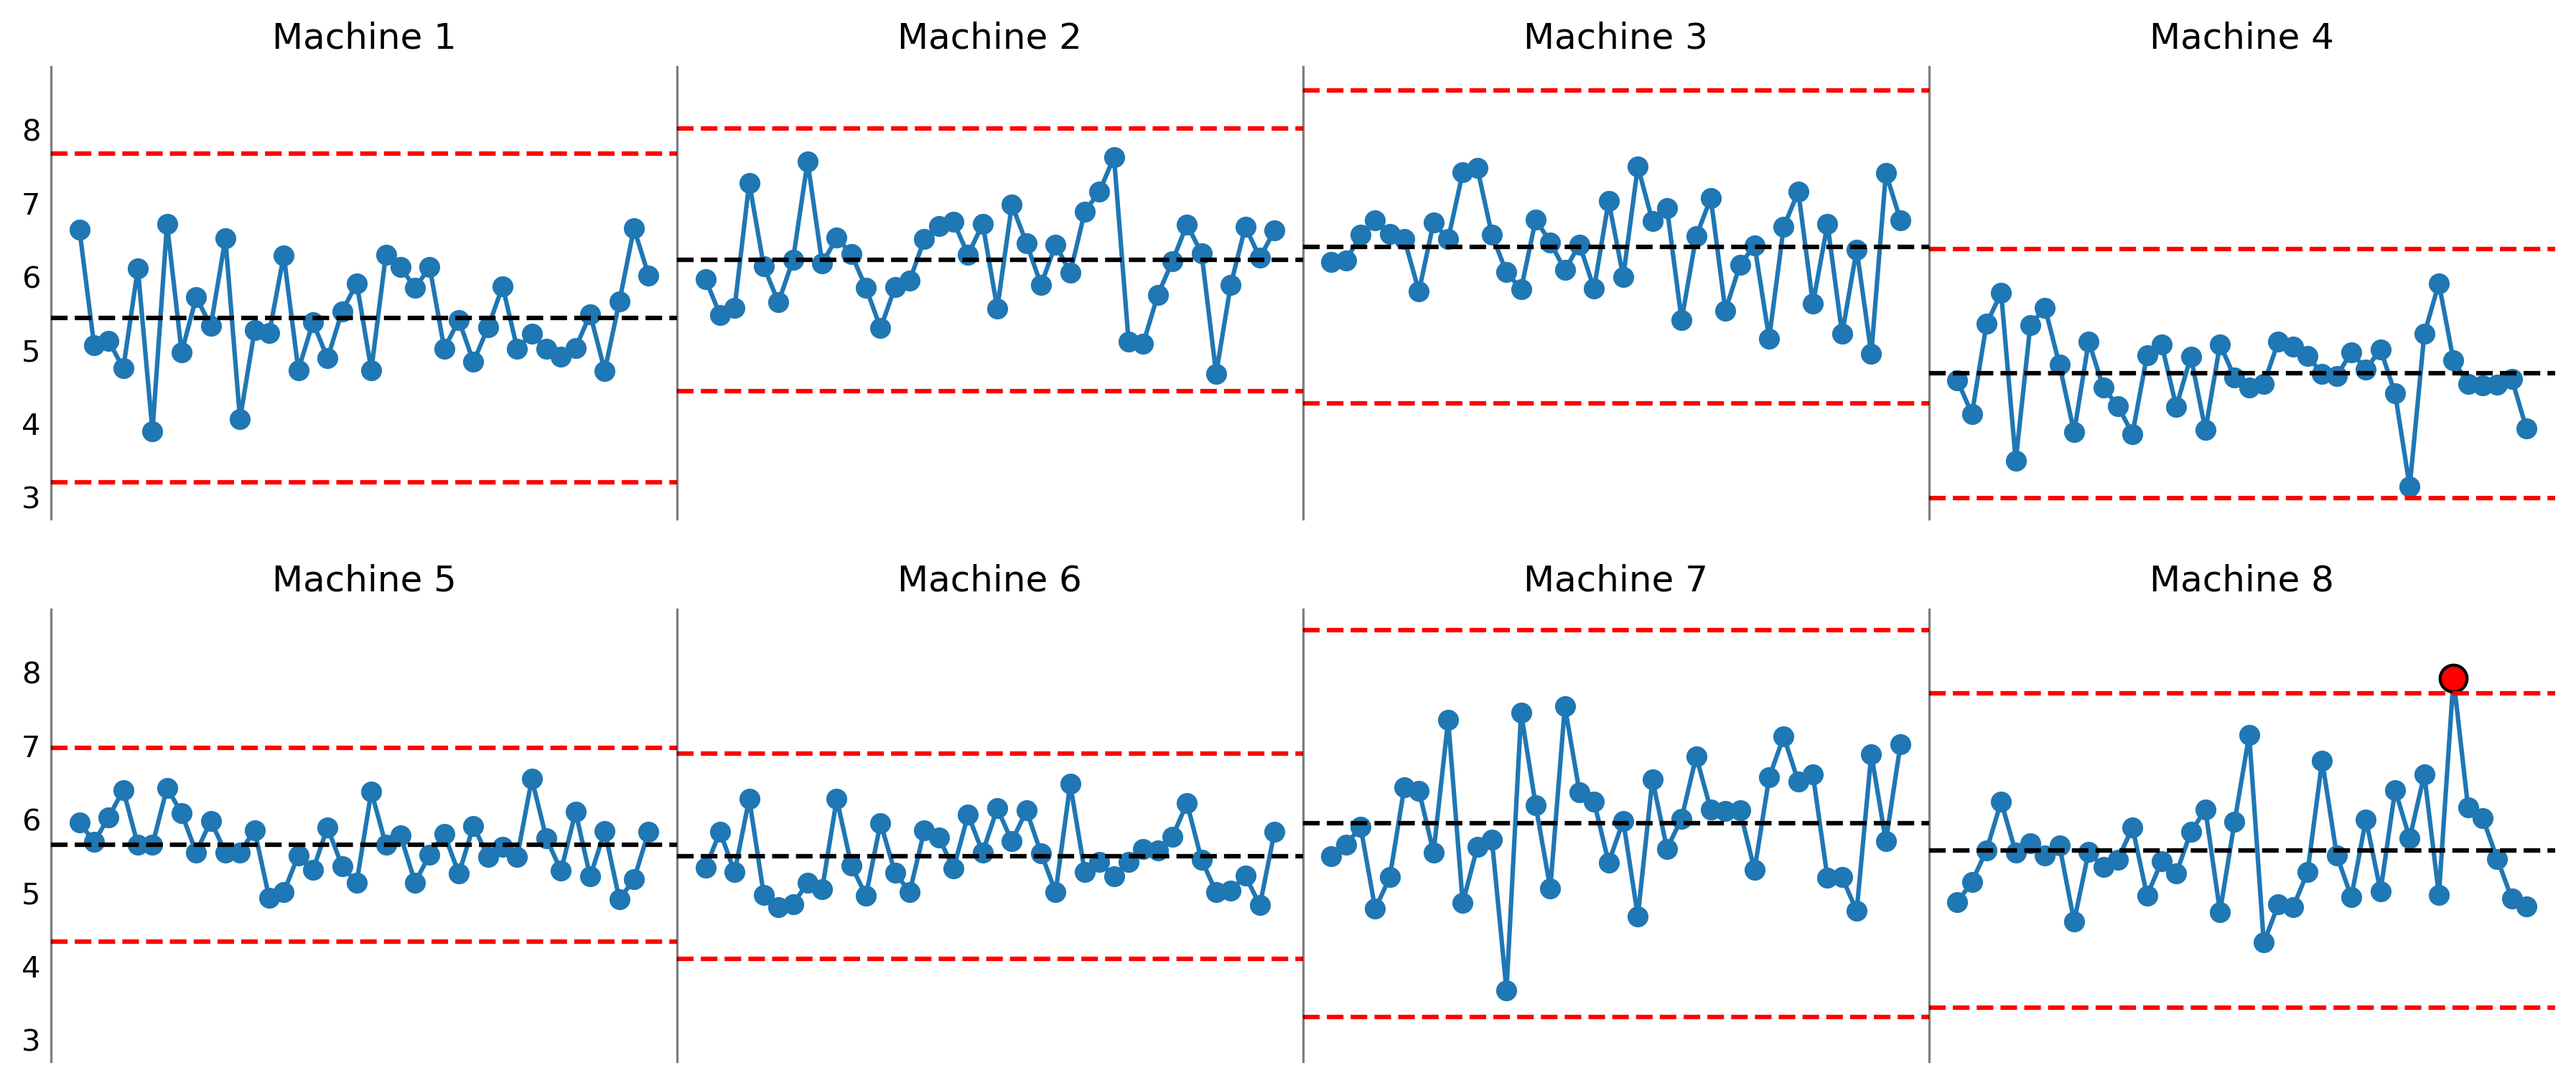

In [14]:
na_results = pi.network_analysis(list_of_dfs, 'Values', list_of_labels, rows=2, cols=4, figsize=(15,6), title='')

In [15]:
round(na_results,1)

,Labels,Mean,UPL,LPL,PLR,AmR,URL,Characterization
0,Machine 1,5.4,7.7,3.2,4.5,0.8,2.8,Predictable
1,Machine 2,6.2,8.0,4.4,3.6,0.7,2.2,Predictable
2,Machine 3,6.4,8.5,4.3,4.3,0.8,2.6,Predictable
3,Machine 4,4.7,6.4,3.0,3.4,0.6,2.1,Predictable
4,Machine 5,5.7,7.0,4.3,2.6,0.5,1.6,Predictable
5,Machine 6,5.5,6.9,4.1,2.8,0.5,1.7,Predictable
6,Machine 7,5.9,8.6,3.3,5.3,1.0,3.2,Predictable
7,Machine 8,5.6,7.7,3.4,4.3,0.8,2.6,Unpredictable


## Figure 7: Network analysis limit chart

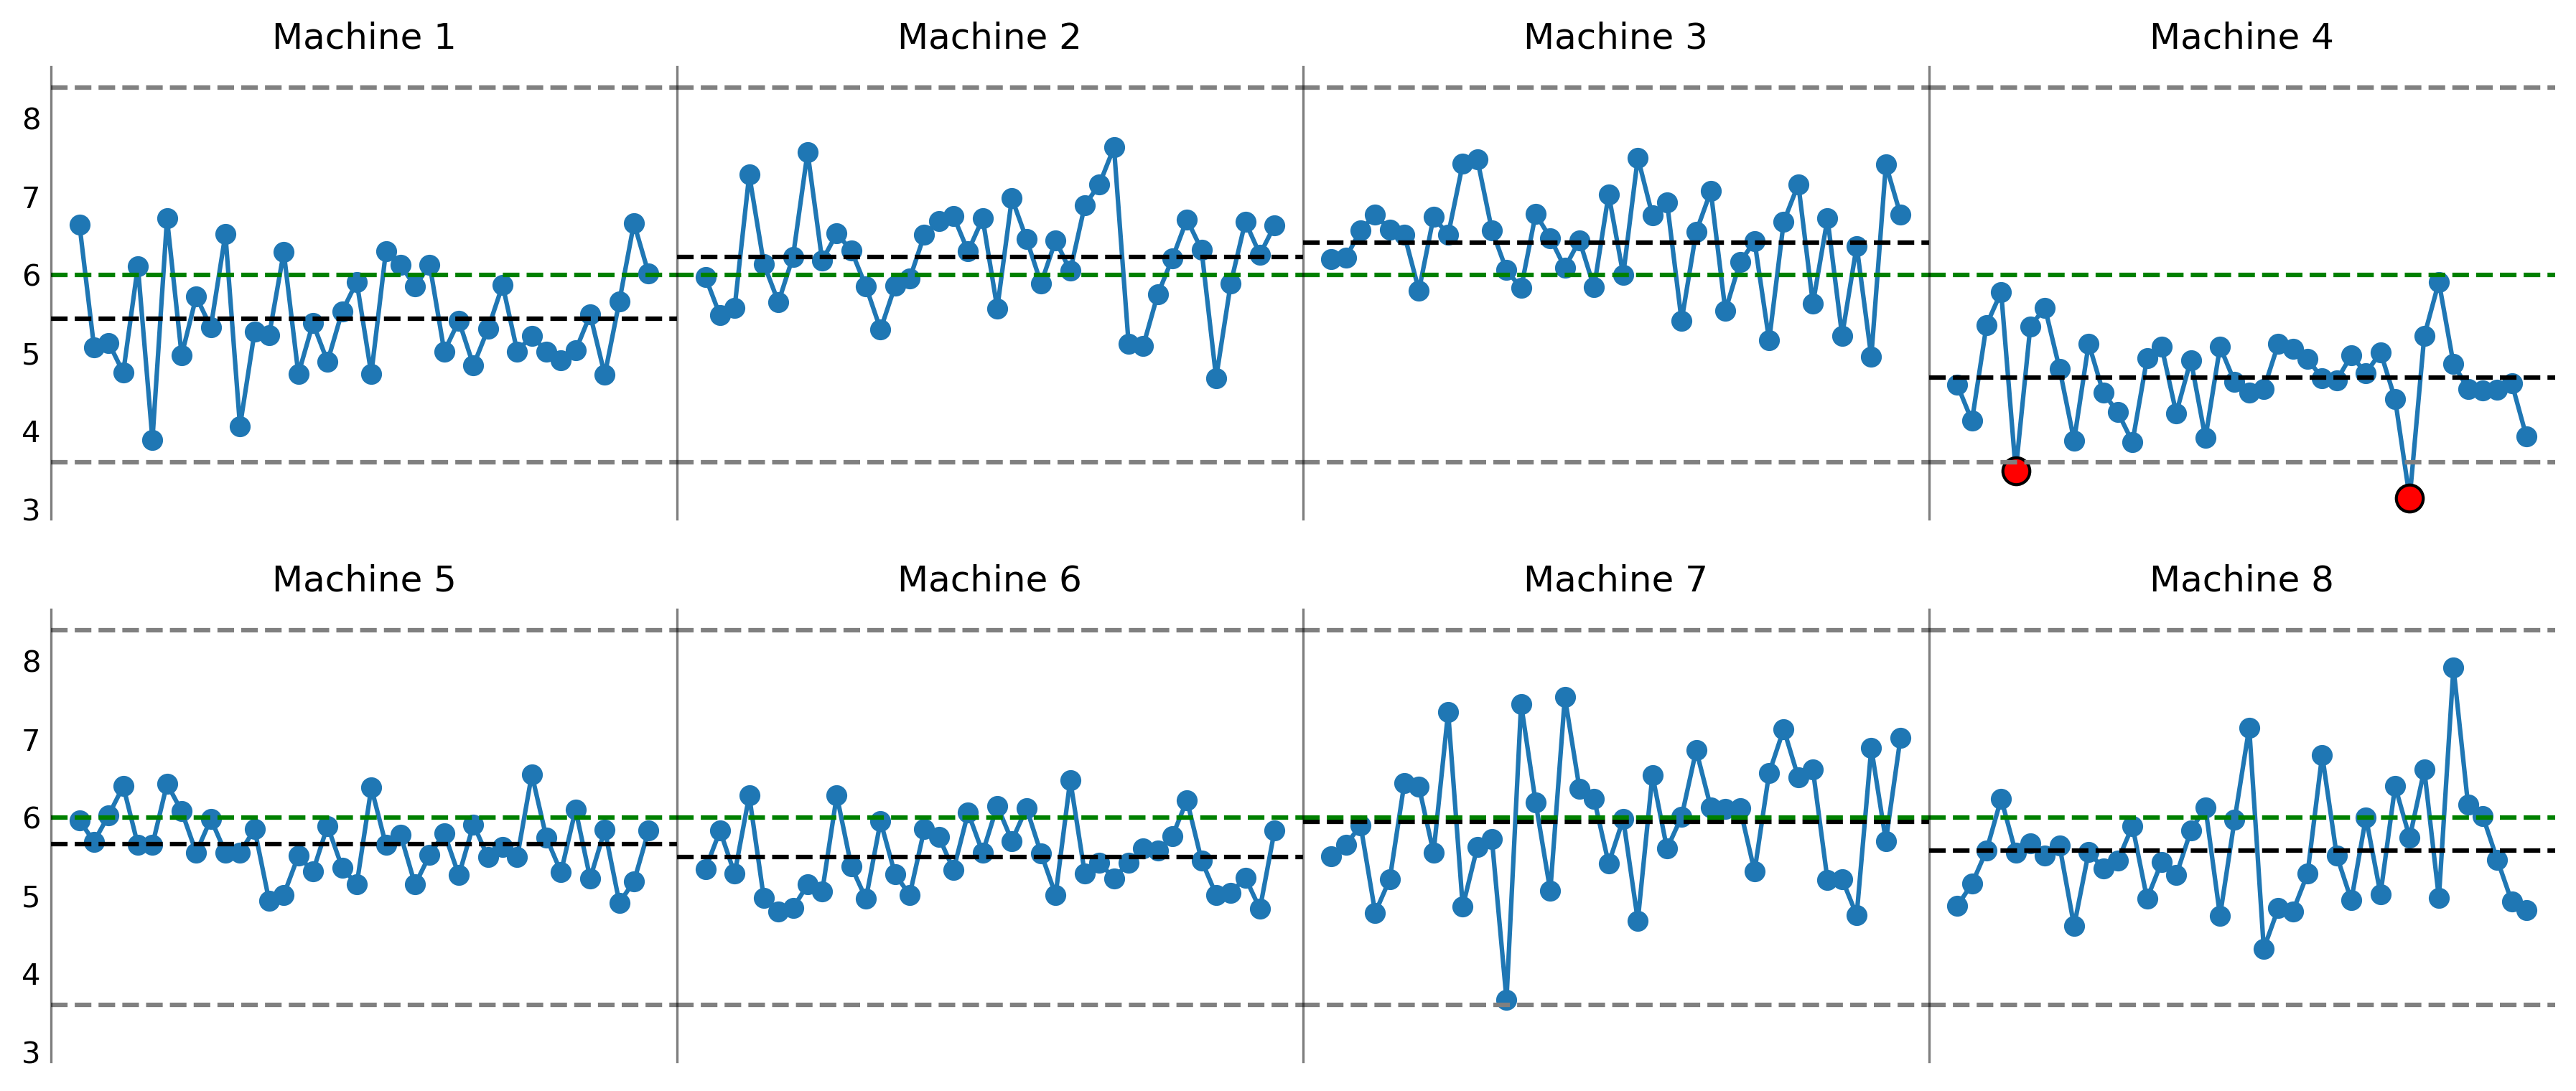

In [16]:
nalp_results = pi.network_analysis_limit_plot(list_of_dfs, 'Values', list_of_labels, 
                                   USL, LSL, target, rows=2, cols=4, figsize=(15,6), title='')

In [17]:
round(nalp_results,1)

,Labels,Mean,UPL,LPL,PLR,Target,USL,LSL,Tolerance,Centering Distance,Tolerance Delta
0,Machine 1,5.4,7.7,3.2,4.5,6,8.4,3.6,4.8,-0.6,-0.3
1,Machine 2,6.2,8.0,4.4,3.6,6,8.4,3.6,4.8,0.2,-1.2
2,Machine 3,6.4,8.5,4.3,4.3,6,8.4,3.6,4.8,0.4,-0.5
3,Machine 4,4.7,6.4,3.0,3.4,6,8.4,3.6,4.8,-1.3,-1.4
4,Machine 5,5.7,7.0,4.3,2.6,6,8.4,3.6,4.8,-0.3,-2.2
5,Machine 6,5.5,6.9,4.1,2.8,6,8.4,3.6,4.8,-0.5,-2.0
6,Machine 7,5.9,8.6,3.3,5.3,6,8.4,3.6,4.8,-0.1,0.5
7,Machine 8,5.6,7.7,3.4,4.3,6,8.4,3.6,4.8,-0.4,-0.5


In [21]:
# Calculate centering distances
na_results['Centering Distance'] = na_results['Mean']-target
centers_sorted = na_results.sort_values(by='Centering Distance')

# Calculate tolerance delta
na_results['Tolerance Delta'] = na_results['PLR']-tolerance
tolerance_deltas_sorted = na_results.sort_values(by='Tolerance Delta',
                                                ascending=False)

## Figure 8: Centering distance bar chart

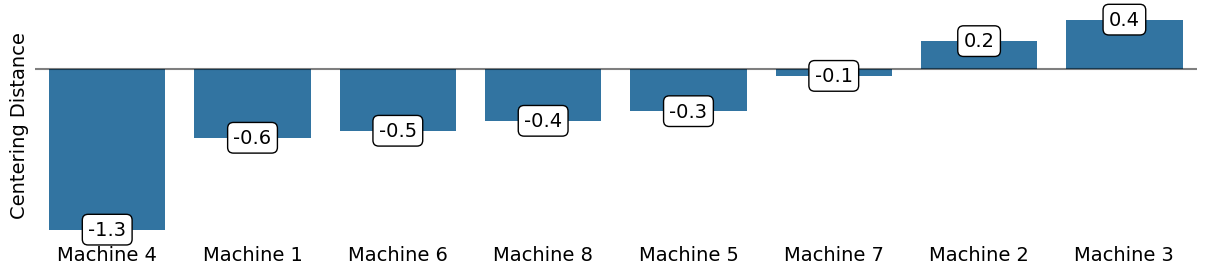

In [35]:
fig, ax = plt.subplots(figsize=(15,3))

barplot = sns.barplot(centers_sorted,y='Centering Distance',x='Labels', color='tab:blue')

# Add labels to each bar
for bar in barplot.patches:
    height = bar.get_height()  # Get the height of the bar
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        y=height,                            # Y-coordinate (top of the bar)
        s=f'{height:.1f}',                   # Text to display
        ha='center',                         # Horizontal alignment
        va='center',
        fontsize=14,
        bbox=dict(facecolor='white', boxstyle='round')
    )

ax.axhline(0, c='black', alpha=0.5)
sns.despine(left=True, bottom=True)
ax.set_ylabel('Centering Distance', fontsize=14)

ax.set(
    xlabel='',
    yticks=[]
)

# Remove xtick marks but keep xtick labels
ax.tick_params(axis='x', length=0, labelsize=14)

## Figure 9: Tolerance deltas

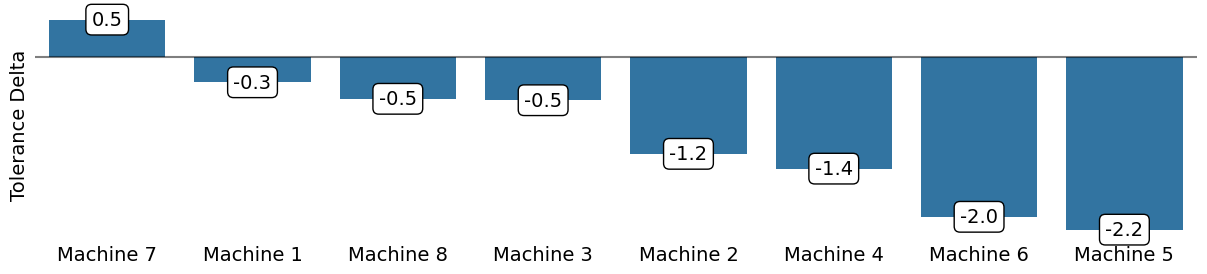

In [33]:
fig, ax = plt.subplots(figsize=(15,3))

barplot = sns.barplot(tolerance_deltas_sorted,y='Tolerance Delta',x='Labels', color='tab:blue')

# Add labels to each bar
for bar in barplot.patches:
    height = bar.get_height()  # Get the height of the bar
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        y=height,                            # Y-coordinate (top of the bar)
        s=f'{height:.1f}',                   # Text to display
        ha='center',                         # Horizontal alignment
        va='center',
        fontsize=14,
        bbox=dict(facecolor='white', boxstyle='round')
    )

ax.axhline(0, c='black', alpha=0.5)

sns.despine(left=True, bottom=True)
ax.set_ylabel('Tolerance Delta', fontsize=14)

ax.set(
    xlabel='',
    yticks=[]
)

# Remove xtick marks but keep xtick labels
ax.tick_params(axis='x', length=0, labelsize=14)